# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [3]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

     |████████████████████████████████| 123 kB 8.8 MB/s 
     |████████████████████████████████| 90 kB 7.7 MB/s 
     |████████████████████████████████| 176 kB 14.5 MB/s 
     |████████████████████████████████| 131 kB 14.5 MB/s 
     |████████████████████████████████| 1.2 MB 10.3 MB/s 
     |████████████████████████████████| 895 kB 54.4 MB/s 
     |████████████████████████████████| 79 kB 10.6 MB/s 
     |████████████████████████████████| 7.8 MB 63.9 MB/s 
     |████████████████████████████████| 138 kB 63.3 MB/s 
     |████████████████████████████████| 127 kB 66.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#!ls /drive/My\ Drive/Medium

ls: cannot access '/drive/My Drive/Medium': No such file or directory


In [5]:
import sys
sys.path.append('/content/drive/MyDrive/dataset/squad')

In [6]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

--2021-08-10 03:15:59--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py’

utils_squad.py      100%[===================>]  40.56K  --.-KB/s    in 0.001s  

2021-08-10 03:15:59 (32.3 MB/s) - ‘utils_squad.py’ saved [41529/41529]

--2021-08-10 03:15:59--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 2

In [7]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
input_file = '/content/drive/MyDrive/dataset/squad/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [10]:
len(examples)

130319

In [11]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [12]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [13]:
train_data1=train_data.sample(frac=0.2).reset_index(drop=True)

In [15]:
len(train_data1)

26064

In [16]:
train_data1.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,572a7a17be1ee31400cb8029,What is Florida's busiest airport?,"[Miami, International, Airport, and, PortMiami...",Miami International,0,1,False
1,5726df19708984140094d433,What are two elements prevalent among characte...,"[In, the, Age, of, Reason, philosophical, trac...",individual experience and emotion,51,54,False
2,5a39739f2f14dd001ac7233b,How many people were in the group of fans that...,"[On, 16, June, 2006,, it, was, announced, that...",,-1,-1,True
3,57301c06947a6a140053d116,Why was Britain able to keep its ancient fores...,"[As, with, most, of, Europe,, prehistoric, Bri...",due to a small population,37,41,False
4,570c5109b3d812140066d0d7,Why did John divert south?,"[Baronial, unrest, in, England, prevented, the...",to counter a threat to Gascony from Alfonso VI...,36,46,False


In [14]:
train_data=train_data1

In [15]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
7970,56e8368700c9c71400d7765d,Why did Ukrainians collaborate with the Axis?,"[After, World, War, II,, due, to, Ukrainian, c...",to gain independence,15,17,False
16228,56e8368700c9c71400d7765b,After what war did Moscow begin to repress the...,"[After, World, War, II,, due, to, Ukrainian, c...",World War II,1,3,False
20302,5ad27f44d7d075001a42975c,What happened to Moscow policy after World War I?,"[After, World, War, II,, due, to, Ukrainian, c...",,-1,-1,True


In [16]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [17]:
print_squad_sample(train_data)

CONTEXT: 
Between 1892, when Harvard and Yale met in one of the first intercollegiate debates,
and 1909, the year of the first Triangular Debate of Harvard, Yale, and Princeton,
the rhetoric, symbolism, and metaphors used in athletics were used to frame these early
debates. Debates were covered on front pages of college newspapers and emphasized in yearbooks,
and team members even received the equivalent of athletic letters for their jackets. There
even were rallies sending off the debating teams to matches. Yet, the debates never
attained the broad appeal that athletics enjoyed. One reason may be that debates do
not have a clear winner, as is the case in sports, and that scoring
is subjective. In addition, with late 19th-century concerns about the impact of modern life
on the human body, athletics offered hope that neither the individual nor the society
was coming apart.
QUESTION:                                                                                            ANSWER:
In wha

In [18]:
len(train_data)

26064

In [19]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
1986,5acff92a77cf76001a6866b5,What account was written in the 1200's?,"[Controversy, persists, over, whether, the, Ru...",,-1,-1,True,229,39
11249,572f96dd04bcaa1900d76ab5,In the 18th century there was one global tradi...,"[Hyderabad's, role, in, the, pearl, trade, has...",Hyderabad,0,0,False,241,85
20780,5728479e2ca10214002da233,In what language were the Vedas ?,"[In, addition, to, the, Vedas,, the, principal...",Sanskrit,15,15,False,180,33
16160,5a36994695360f001af1b29e,On what date in November 1918 was the Indepen...,"[In, February, 1918,, he, was, appointed, Offi...",,-1,-1,True,209,71
11524,56df880c56340a1900b29d16,How old was Mabel when she became deaf?,"[Deciding, to, give, up, his, lucrative, priva...",15,21,21,False,180,39


In [20]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.2658072437078%


In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 861545.27B/s]


In [22]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [23]:
cached_features_file = '/content/drive/MyDrive/dataset/squad/cache_train'

In [24]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [25]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [26]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [27]:
len(dataset)

144262

In [28]:
train_sampler = RandomSampler(dataset,replacement=True, num_samples=int(0.2*len(dataset)))
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [29]:
len(train_sampler)

28852

In [30]:
len(train_dataloader)

1803

In [31]:
import glob
checkpoints = sorted(glob.glob('/content/drive/MyDrive/dataset/squad/checkpoint*-[0-9]*'))

In [32]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [33]:
'''
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/content/drive/MyDrive/dataset/squad/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
'''
global_step = 0
train_loss_set = []
tr_loss = 0.0
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

100%|██████████| 440473133/440473133 [00:12<00:00, 36062297.80B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [34]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-0.0066,  0.0166,  0.0302,  ...,  0.0150,  0.0055,  0.0270],
        [-0.0051, -0.0123, -0.0080,  ...,  0.0281,  0.0351,  0.0363]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [35]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [36]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/content/drive/MyDrive/dataset/squad/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

Iteration:   0%|          | 0/1803 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 1803


/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  55%|█████▌    | 1000/1803 [13:25<10:51,  1.23it/s]

Train loss: 1.7664008285999298



Iteration:  56%|█████▌    | 1001/1803 [13:32<34:54,  2.61s/it]

Saving model checkpoint to /content/drive/MyDrive/dataset/squad/checkpoint-1000



Epoch: 100%|██████████| 1/1 [24:21<00:00, 1461.85s/it]


In [37]:
output_dir = '/content/drive/MyDrive/dataset/squad/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [39]:
train_loss_set_ckpt = torch.load('/content/drive/MyDrive/dataset/squad/checkpoint-4000/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

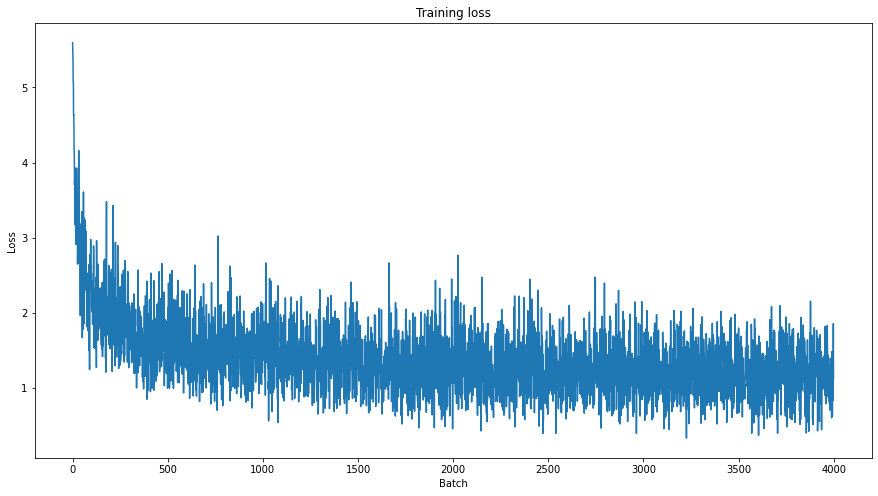

In [40]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [41]:
input_file = '/content/drive/MyDrive/dataset/squad/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/content/drive/MyDrive/dataset/squad/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [42]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [43]:
len(dataset)

7205

In [44]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

In [46]:
batch=next(iter(validation_dataloader))

In [48]:
batch = tuple(t.to(device) for t in batch)

In [50]:
with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

In [69]:
all_results = []
predict_file = '/content/drive/MyDrive/dataset/squad//dev-v2.0.json'
for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)
      print(unique_id)
      result = RawResult(unique_id = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits = to_list(outputs[1][i]))
      print(result)
      print(len(result))
      all_results.append(result)

1000000000
RawResult(unique_id=1000000000, start_logits=[3.0231916904449463, -4.312466144561768, -3.658334255218506, -4.059244632720947, -5.253526210784912, 1.4417351484298706, -4.667718887329102, -6.958146095275879, -5.719076633453369, -1.7143745422363281, -1.2326923608779907, -7.076269149780273, -5.964037895202637, -3.596182346343994, -6.81210994720459, -3.2908644676208496, -6.39608097076416, -6.647514343261719, -6.794442653656006, -6.242027282714844, -1.3889907598495483, -5.675502777099609, -2.4893343448638916, -7.0022454261779785, -6.571961879730225, -4.387829780578613, -6.849709510803223, -3.714475154876709, -7.217692852020264, -7.684870719909668, -5.408590316772461, -3.8801112174987793, -5.432180881500244, -6.8592987060546875, -4.656974792480469, -4.327561378479004, -2.8019702434539795, -6.226039409637451, -4.716756820678711, -6.475031852722168, -3.653174877166748, -5.468684673309326, -5.4462480545043945, -4.461548328399658, 3.335984706878662, -3.5832390785217285, 3.2009117603302

In [72]:
len(all_results)

16

In [77]:
# Compute predictions
output_prediction_file = "/content/drive/MyDrive/dataset/squad/predictions.json"
output_nbest_file = "/content/drive/MyDrive/dataset/squad/nbest_predictions.json"
output_null_log_odds_file = "/content/drive/MyDrive/dataset/squad/null_odds.json"
output_dir = "/content/drive/MyDrive/dataset/squad/predict_results"

write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  False, 0.0)

KeyError: ignored

In [78]:
all_results

[RawResult(unique_id=1000000000, start_logits=[3.0231916904449463, -4.312466144561768, -3.658334255218506, -4.059244632720947, -5.253526210784912, 1.4417351484298706, -4.667718887329102, -6.958146095275879, -5.719076633453369, -1.7143745422363281, -1.2326923608779907, -7.076269149780273, -5.964037895202637, -3.596182346343994, -6.81210994720459, -3.2908644676208496, -6.39608097076416, -6.647514343261719, -6.794442653656006, -6.242027282714844, -1.3889907598495483, -5.675502777099609, -2.4893343448638916, -7.0022454261779785, -6.571961879730225, -4.387829780578613, -6.849709510803223, -3.714475154876709, -7.217692852020264, -7.684870719909668, -5.408590316772461, -3.8801112174987793, -5.432180881500244, -6.8592987060546875, -4.656974792480469, -4.327561378479004, -2.8019702434539795, -6.226039409637451, -4.716756820678711, -6.475031852722168, -3.653174877166748, -5.468684673309326, -5.4462480545043945, -4.461548328399658, 3.335984706878662, -3.5832390785217285, 3.2009117603302, 0.819699

**Evaluate test dataset**

In [81]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/MyDrive/dataset/squad//dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      #print(result)
      all_results.append(result)
  
  # Compute predictions
  output_prediction_file = "/content/drive/MyDrive/dataset/squad/predictions.json"
  output_nbest_file = "/content/drive/MyDrive/dataset/squad/nbest_predictions.json"
  output_null_log_odds_file = "/content/drive/MyDrive/dataset/squad/null_odds.json"
  output_dir = "/content/drive/MyDrive/dataset/squad/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  
  return results

In [82]:
results = evaluate(model, tokenizer)


Evaluating:   0%|          | 0/450 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 7205
  Batch size = 16



Evaluating: 100%|██████████| 450/450 [01:55<00:00,  3.90it/s]


KeyError: ignored

In [ ]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

**Evaluate on any text**